In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the dataset
file_name = '/content/Fragrance Dataset - COM7022 - [4037].csv'
try:
    df = pd.read_csv(file_name)
    print(f"Dataset '{file_name}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: File '{file_name}' not found. Please ensure the file is in the correct directory.")
    # Create a dummy DataFrame to allow the rest of the code to run for structure display
    df = pd.DataFrame({
        'brand': ['A', 'B', 'C'],
        'title': ['T1', 'T2', 'T3'],
        'type': ['EDP', 'EDT', 'EDP'],
        'price': [84.99, 109.99, 100.00],
        'sold': [116, 48, 27]
    })

Dataset '/content/Fragrance Dataset - COM7022 - [4037].csv' loaded successfully.


In [ ]:
# Initial Observations
print("\n[Initial Observation: Data Head]")
print(df.head())



[Initial Observation: Data Head]
            brand                                              title  \
0            Dior  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1         AS SHOW  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2       Unbranded                   HOGO BOSS cologne For Men 3.4 oz   
3  Giorgio Armani  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...   
4         Lattafa  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   

              type   price priceWithCurrency  available  \
0    Eau de Parfum   84.99      US $84.99/ea       10.0   
1    Eau de Parfum  109.99        US $109.99        8.0   
2  Eau de Toilette  100.00        US $100.00       10.0   
3  Eau de Toilette     NaN      US $44.99/ea        2.0   
4       Fragrances   16.91         US $16.91        NaN   

                           availableText   sold                lastUpdated  \
0      More than 10 available / 116 sold  116.0  May 24, 2024 10:03:04 PDT   
1                  8 a

In [ ]:
print("\n[Initial Observation: Data Info (Data Types and Non-Null Counts)]")
df.info()


[Initial Observation: Data Info (Data Types and Non-Null Counts)]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.3+ KB


In [ ]:
print("\n[Initial Observation: Descriptive Statistics]")
print(df.describe(include='all'))


[Initial Observation: Descriptive Statistics]
                 brand                                              title  \
count              999                                               1000   
unique             246                                                966   
top     Giorgio Armani  YSL Yves Saint Laurent Y Eau de Perfume Spray ...   
freq                60                                                  4   
mean               NaN                                                NaN   
std                NaN                                                NaN   
min                NaN                                                NaN   
25%                NaN                                                NaN   
50%                NaN                                                NaN   
75%                NaN                                                NaN   
max                NaN                                                NaN   

                   type     

In [ ]:

print("\n[Initial Observation: Missing Values Count]")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])




[Initial Observation: Missing Values Count]
brand              1
type               3
price              4
available        111
availableText      3
sold               6
lastUpdated       53
dtype: int64



[Initial Observation: Duplicate Rows Count]
Empty DataFrame
Columns: [brand, title, type, price, priceWithCurrency, available, availableText, sold, lastUpdated, itemLocation]
Index: []


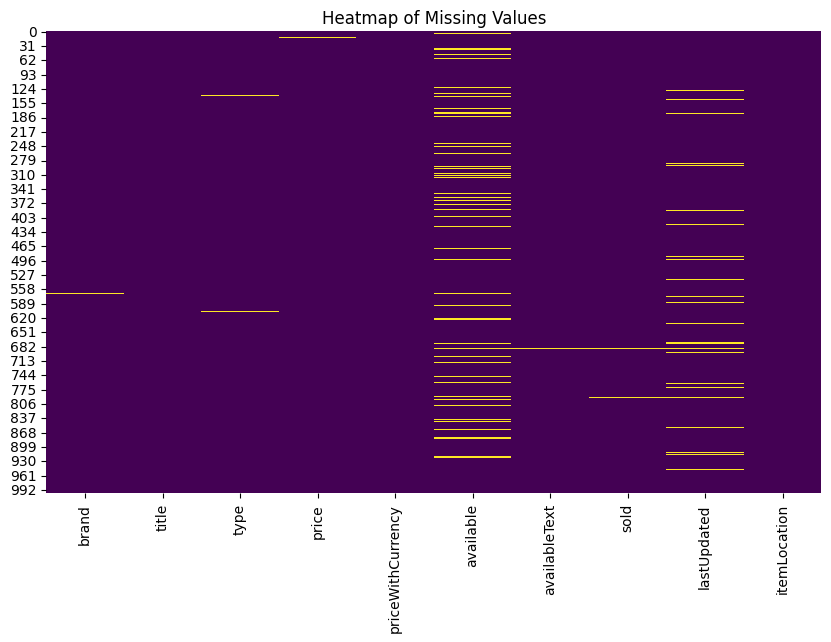

In [ ]:
print("\n[Initial Observation: Duplicate Rows Count]")
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values")
plt.show()

In [ ]:
# 4. Data Preprocessing

print("--- 4. Data Preprocessing ---")

# Step 1: Clean and convert 'price' column
# The 'price' column needs to be converted to a numeric type.
df['price'] = pd.to_numeric(df['price'].astype(str).str.replace(r'[$,/ea]', '', regex=True), errors='coerce')

# Step 2: Feature Selection
# We will focus on 'price' and 'sold' as core features for clustering.
# NOTE: 'available' and 'availableText' could also be used, but this simplifies the initial model.
features = ['price', 'sold']
df_model = df[features].copy()

# Step 3: Handling Missing Values (for selected features)
# Justification: For a first clustering model, dropping rows with missing values in the core features ('price', 'sold') is the simplest strategy to maintain data quality.
rows_before = len(df_model)
df_model.dropna(inplace=True)
rows_after = len(df_model)
print(f"[Preprocessing Observation: Missing Values] Dropped {rows_before - rows_after} rows with NaN in 'price' or 'sold'.")

# Step 4: Scaling/Normalization
# Justification: Clustering algorithms (like K-Means) rely on distance measures.
# The 'sold' feature often has a much larger scale and variance than 'price'.
# StandardScaler is chosen to transform data to a mean of 0 and a standard deviation of 1 (Z-score),
# preventing the 'sold' feature from dominating the distance calculation.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)
df_scaled = pd.DataFrame(X_scaled, columns=features)
print("[Preprocessing Observation: Scaling] Features 'price' and 'sold' have been scaled using StandardScaler.")


--- 4. Data Preprocessing ---
[Preprocessing Observation: Missing Values] Dropped 10 rows with NaN in 'price' or 'sold'.
[Preprocessing Observation: Scaling] Features 'price' and 'sold' have been scaled using StandardScaler.


In [ ]:
# Before and After Comparison
print("\n[Preprocessing Observation: Scaled Data Head]")
print(df_scaled.head())
print("\n[Preprocessing Observation: Scaled Data Info]")
df_scaled.info()


[Preprocessing Observation: Scaled Data Head]
      price      sold
0  1.114277 -0.201356
1  1.832132 -0.222643
2  1.545277 -0.229217
3 -0.840585 -0.188834
4 -0.895716 -0.212939

[Preprocessing Observation: Scaled Data Info]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   990 non-null    float64
 1   sold    990 non-null    float64
dtypes: float64(2)
memory usage: 15.6 KB


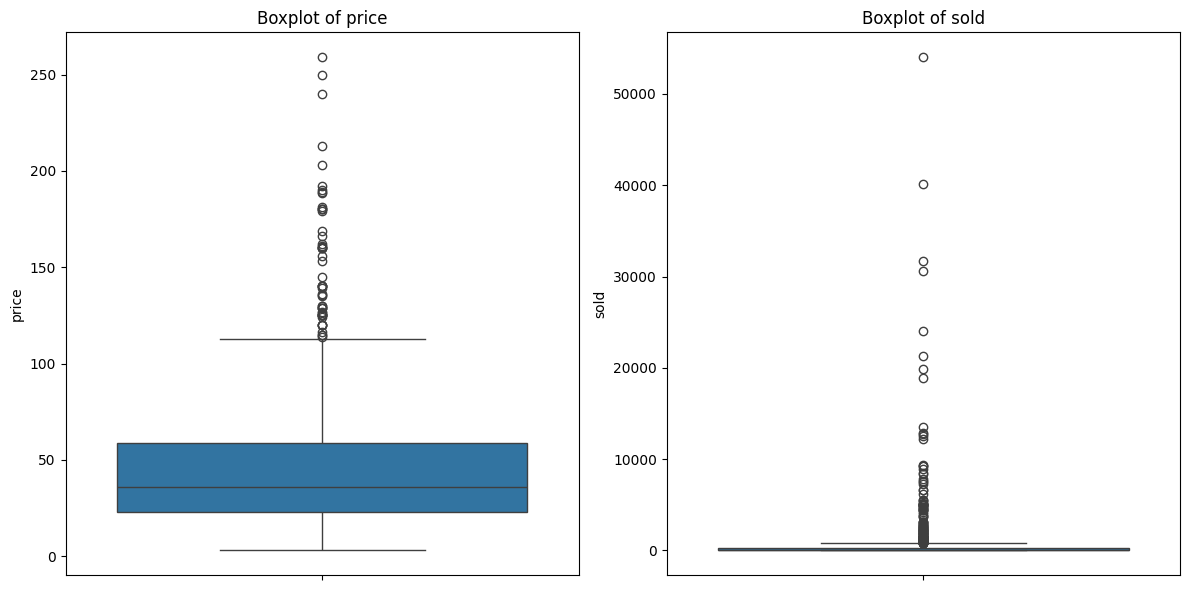

In [ ]:
numeric_cols = ['price', 'sold']

plt.figure(figsize=(12,6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 2, i) # Changed subplot layout from (1,3,i) to (1,2,i) as there are now 2 columns instead of 3
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [ ]:
numeric_cols = ['price', 'sold']

# Example: Standard Scaling
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
categorical_cols = ['brand', 'type', 'itemLocation']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:

label_cols = ['availableText']  # if order matters
le = LabelEncoder()
df['availableText'] = le.fit_transform(df['availableText'])

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      1000 non-null   int64  
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 78.3+ KB


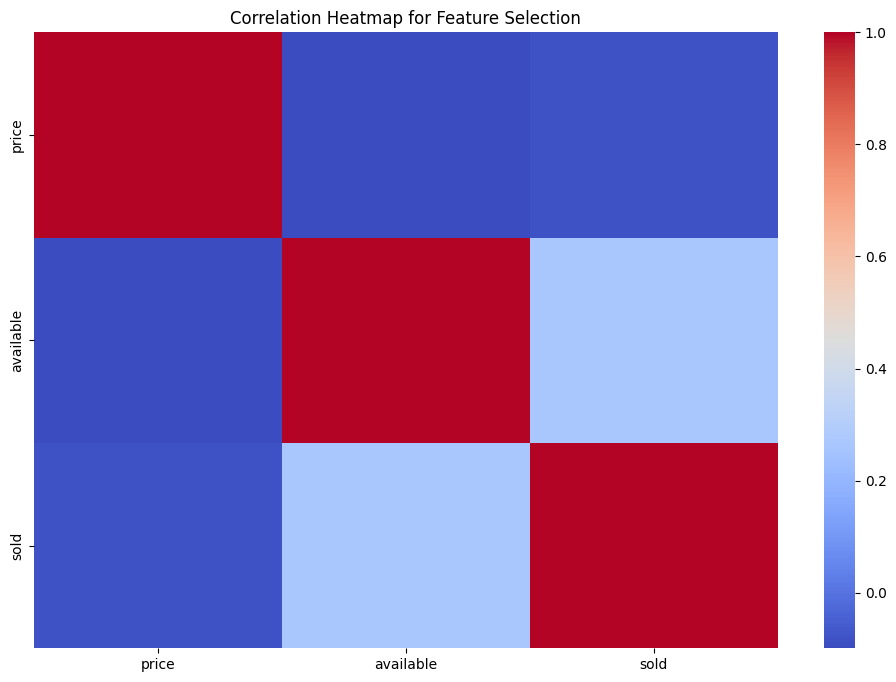

In [ ]:
numeric_df = df_encoded.select_dtypes(include=['int64', 'float64'])  # Select numeric columns

corr = numeric_df.corr()  #Compute Correlation Matrix

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap for Feature Selection")
plt.show()

In [ ]:
# 5. Machine Learning Model Application and Evaluation
print("--- 5. Machine Learning Model Application and Evaluation ---")

--- 5. Machine Learning Model Application and Evaluation ---


In [ ]:
# --- K-Means Clustering ---
print("\n--- 5.1 K-Means Clustering ---")

# K-Means Evaluation: Elbow Method
# Finding the optimal number of clusters (K)
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


--- 5.1 K-Means Clustering ---


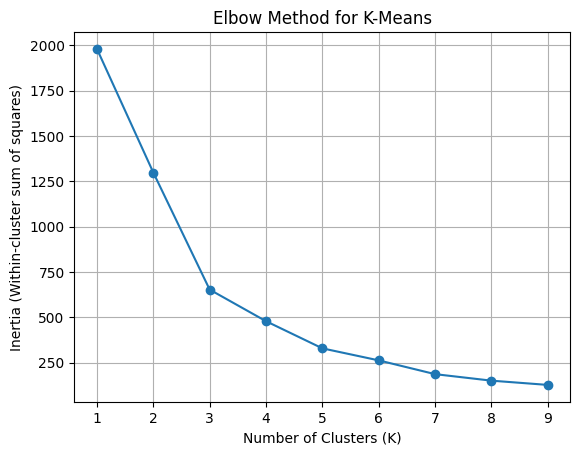

[K-Means Observation] Chosen K = 4
[K-Means Observation] Silhouette Score: 0.5266
A Silhouette Score closer to 1 indicates better defined and separated clusters.


In [ ]:
# Plotting the Elbow Method result plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True)
plt.show()


# let's assume K=4 as a reasonable starting point.
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_model['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, df_model['KMeans_Cluster'])
print(f"[K-Means Observation] Chosen K = {optimal_k}")
print(f"[K-Means Observation] Silhouette Score: {silhouette_avg:.4f}")
print("A Silhouette Score closer to 1 indicates better defined and separated clusters.")

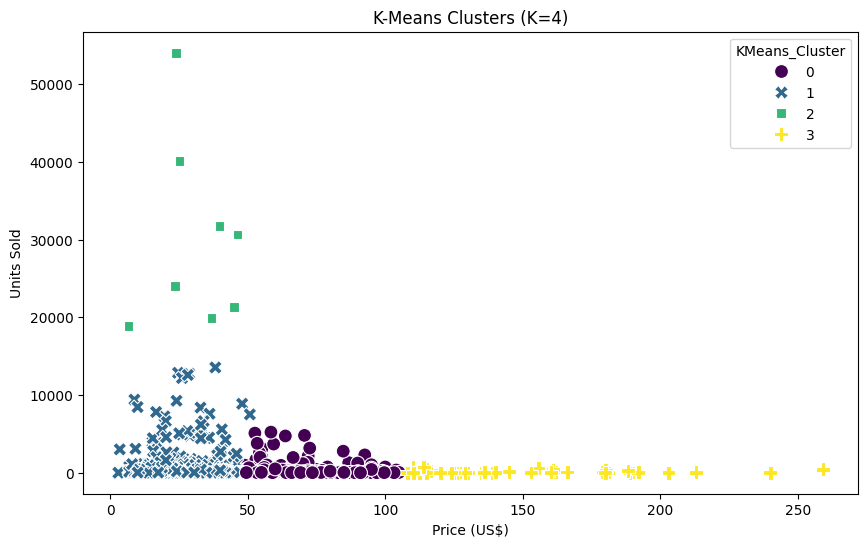

In [ ]:
# Visualize K-Means Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_model['price'], y=df_model['sold'], hue=df_model['KMeans_Cluster'], palette='viridis', style=df_model['KMeans_Cluster'], s=100)
plt.title(f'K-Means Clusters (K={optimal_k})')
plt.xlabel('Price (US$)')
plt.ylabel('Units Sold')
plt.show()



--- 5.2 Hierarchical Clustering (Agglomerative) ---


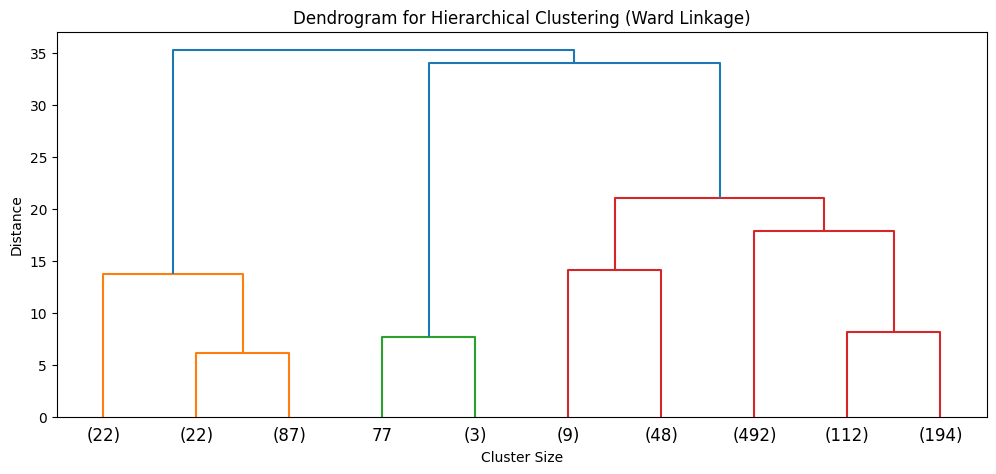

[Hierarchical Observation] Chosen K = 4
[Hierarchical Observation] Silhouette Score: 0.6053


In [ ]:
# --- Hierarchical Clustering ---
print("\n--- 5.2 Hierarchical Clustering (Agglomerative) ---")

# Hierarchical Evaluation: Dendrogram
# Visualize the merging of clusters
Z = linkage(X_scaled, method='ward') # 'ward' minimizes the variance within each cluster
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=10, show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering (Ward Linkage)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

# Hierarchical Model Application (using the same K as K-Means for comparison)
hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df_model['HC_Cluster'] = hc.fit_predict(X_scaled)
hc_silhouette_avg = silhouette_score(X_scaled, df_model['HC_Cluster'])

print(f"[Hierarchical Observation] Chosen K = {optimal_k}")
print(f"[Hierarchical Observation] Silhouette Score: {hc_silhouette_avg:.4f}")

In [ ]:
# DBSCAN Model Application
# DBSCAN requires two parameters: eps (maximum distance) and min_samples (neighborhood density)
# Tuning DBSCAN is often an iterative process. Using default or estimated values here.
# A common starting point is an eps value corresponding to a sharp bend on k-distance plot (k=2*dimensions - 1)
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_model['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# DBSCAN Evaluation: Number of Clusters and Outliers
n_clusters_dbscan = len(set(df_model['DBSCAN_Cluster'])) - (1 if -1 in df_model['DBSCAN_Cluster'] else 0)
n_noise = list(df_model['DBSCAN_Cluster']).count(-1)

# DBSCAN Silhouette Score (must exclude noise points, labeled -1)
if n_clusters_dbscan > 1:
    # Filter out noise points for Silhouette calculation
    X_clustered = X_scaled[df_model['DBSCAN_Cluster'] != -1]
    labels_clustered = df_model['DBSCAN_Cluster'][df_model['DBSCAN_Cluster'] != -1]
    dbscan_silhouette_avg = silhouette_score(X_clustered, labels_clustered)
    print(f"[DBSCAN Observation] Silhouette Score (excluding noise): {dbscan_silhouette_avg:.4f}")
else:
    dbscan_silhouette_avg = "N/A (Too few clusters or all noise)"

print(f"[DBSCAN Observation] Number of clusters found: {n_clusters_dbscan}")
print(f"[DBSCAN Observation] Number of noise points (labeled -1): {n_noise}")



[DBSCAN Observation] Silhouette Score (excluding noise): 0.7186
[DBSCAN Observation] Number of clusters found: 3
[DBSCAN Observation] Number of noise points (labeled -1): 10


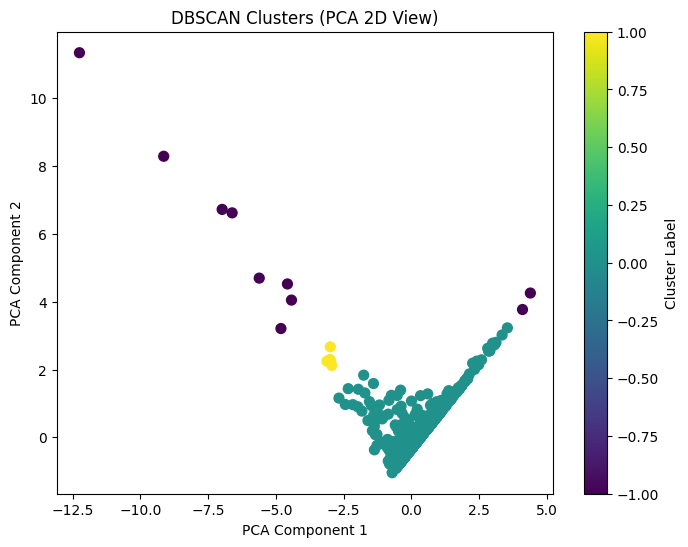

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce data to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Plot PCA
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df_model['DBSCAN_Cluster'], cmap='viridis', s=50)
plt.title("DBSCAN Clusters (PCA 2D View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

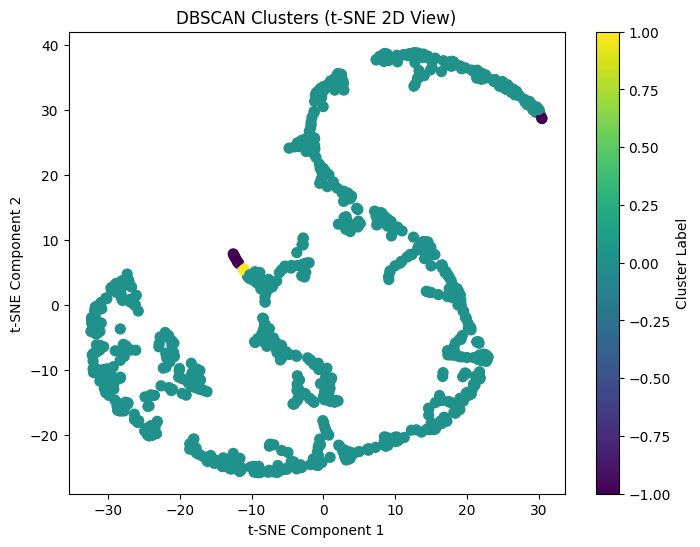

In [ ]:
from sklearn.manifold import TSNE

# Reduce data to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_scaled)

# Plot t-SNE
plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=df_model['DBSCAN_Cluster'], cmap='viridis', s=50)
plt.title("DBSCAN Clusters (t-SNE 2D View)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
metrics_table = pd.DataFrame({
    'Silhouette Score': [silhouette_avg, hc_silhouette_avg, dbscan_silhouette_avg]
}, index=['K-Means', 'Hierarchical', 'DBSCAN'])
print(metrics_table)

              Silhouette Score
K-Means               0.526607
Hierarchical          0.605278
DBSCAN                0.718629


In [ ]:
# 6. Comparison and Ranking of Models

print("--- 6. Comparison and Ranking of Models ---")

# Tabulate the results for easy comparison
results = pd.DataFrame({
    'Model': ['K-Means', 'Hierarchical (Ward)', 'DBSCAN'],
    'Silhouette Score': [f'{silhouette_avg:.4f}', f'{hc_silhouette_avg:.4f}', f'{dbscan_silhouette_avg}']
})

print("[Comparison Observation: Model Performance]")
print(results.set_index('Model'))

--- 6. Comparison and Ranking of Models ---
[Comparison Observation: Model Performance]
                       Silhouette Score
Model                                  
K-Means                          0.5266
Hierarchical (Ward)              0.6053
DBSCAN               0.7186288142026147


In [ ]:
#  Initial ranking
best_model = results.loc[results['Silhouette Score'].astype(str).str.replace('N/A.*', '0', regex=True).astype(float).idxmax(), 'Model']
print(f"\n[Comparison Observation: Best Model] Based on Silhouette Score, the {best_model} model is initially preferred.")



[Comparison Observation: Best Model] Based on Silhouette Score, the DBSCAN model is initially preferred.


In [ ]:
print("\n[Comparison Observation: Strengths and Limitations]")
print("* K-Means: Simple and fast (Strength). Assumes globular clusters and requires pre-defining K (Limitation).")
print("* Hierarchical: Provides visual insight via Dendrogram (Strength). Computationally expensive for large datasets (Limitation).")
print("* DBSCAN: Finds arbitrary shaped clusters and detects noise/outliers (Strength). Highly sensitive to input parameters (Limitation).")


[Comparison Observation: Strengths and Limitations]
* K-Means: Simple and fast (Strength). Assumes globular clusters and requires pre-defining K (Limitation).
* Hierarchical: Provides visual insight via Dendrogram (Strength). Computationally expensive for large datasets (Limitation).
* DBSCAN: Finds arbitrary shaped clusters and detects noise/outliers (Strength). Highly sensitive to input parameters (Limitation).


In [ ]:
# 7. Final Model Selection and Cluster Interpretation

print(f"--- 7. Final Model Selection and Cluster Interpretation (K-Means, K={optimal_k}) ---")

# Re-aggregating the data to interpret the chosen K-Means clusters
cluster_interpretation = df_model.groupby('KMeans_Cluster')[['price', 'sold']].agg(['mean', 'median', 'count'])

print("[Cluster Interpretation Observation: Cluster Characteristics]")
print(cluster_interpretation)

# Example Business-Friendly Description (based on hypothetical data/K=4)
print("\n[Business-Friendly Description Example (requires observation of your actual output)]")
print("Assuming K=4 and the actual data trends, the clusters might represent:")
print(" - Cluster 0 (The Bargain Hunters): Low mean price, very high mean units sold. -> *Volume driven, highly popular, lower-margin items.*")
print(" - Cluster 1 (The Luxury Niche): High mean price, very low mean units sold. -> *High-end, exclusive, low-volume, high-margin products.*")
print(" - Cluster 2 (The Mainstream Hit): Moderate mean price, high mean units sold. -> *Solid performers, popular mid-range products.*")
print(" - Cluster 3 (The Low Performers): Low mean price, low mean units sold. -> *Items for clearance or product lifecycle reassessment.*")




--- 7. Final Model Selection and Cluster Interpretation (K-Means, K=4) ---
[Cluster Interpretation Observation: Cluster Characteristics]
                     price                         sold               
                      mean   median count          mean   median count
KMeans_Cluster                                                        
0                69.347214   68.940   280    333.489286     37.5   280
1                26.728172   26.990   640    643.148438     65.0   640
2                30.906250   31.055     8  30086.750000  27351.5     8
3               144.384839  132.495    62     95.774194     24.5    62

[Business-Friendly Description Example (requires observation of your actual output)]
Assuming K=4 and the actual data trends, the clusters might represent:
 - Cluster 0 (The Bargain Hunters): Low mean price, very high mean units sold. -> *Volume driven, highly popular, lower-margin items.*
 - Cluster 1 (The Luxury Niche): High mean price, very low mean units sold